In [75]:
# Importing the required packages
import calliope
import pandas as pd
from spores_algorithm import run_spores
from plotting_utilities import plot_dispatch, plot_capacity, plot_network
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

# Set the number of threads to 1
os.environ["OMP_NUM_THREADS"] = "1"


calliope.set_log_verbosity('INFO', include_solver_output=False) # Defines how much information you get 
                                                               #from the machine as the model gets built and run

Loads all SPORE NetCDF files, aggregates source capacities by technology for each SPORE, and builds a matrix with SPOREs as rows and technologies as columns.

In [76]:
# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the aggregated data for each SPORE
aggregated_data_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Convert source capacities to DataFrame
    data_source = data['source_cap'].to_dataframe().reset_index()
    
    # Filter out any "_to_" techs and drop NaN values in source_cap
    data_source = data_source[~data_source['techs'].str.contains(r'_to_', regex=True)]
    data_source = data_source.dropna(subset=['source_cap'])
    
    # Aggregate the source capacities by tech
    aggregated_source_cap = data_source.groupby('techs')['source_cap'].sum().reset_index()
    
    # Convert the aggregated source capacities into a series with tech as the index
    aggregated_series = aggregated_source_cap.set_index('techs')['source_cap']
    
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    aggregated_series.name = spore_name  # Name the row by the SPORE name

    # Append the aggregated data (this will form the rows in the final matrix)
    aggregated_data_list.append(aggregated_series)

# Combine all SPORE aggregated data into a single DataFrame (with each SPORE as a row)
aggregated_matrix = pd.concat(aggregated_data_list, axis=1).T

# Set the column names to be the techs
aggregated_matrix.columns = aggregated_source_cap['techs']

# Show the resulting matrix
aggregated_matrix


techs,bioenergy,ccgt,coal,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_1,16045.254451,2895.445684,0.011647,3230.094173,3.721065e-09,1487.733845,6460.703627,4133.587573,12419.098827
spores\maxbat_spore_2,16079.682601,2870.946341,0.069804,3552.789002,2.090733e-08,1487.751263,6460.703899,4133.587088,12418.254186
spores\maxbat_spore_3,16064.476703,2876.685989,0.024541,3879.994531,7.454966e-09,1487.738068,6460.703660,4133.587494,12418.998094
spores\maxbat_spore_4,16207.613368,2797.513711,1.498043,3308.526427,6.184824e-07,1488.249338,6460.714893,4133.592228,12351.144275
spores\maxbat_spore_5,16383.987528,2711.147792,0.002973,3364.330085,0.000000e+00,1487.731039,6460.703580,4133.587599,12180.738962
spores\maxbio_spore_1,24715.600274,2651.214323,1925.416056,933.737436,9.668447e-04,2233.339406,6494.209940,4139.712854,9059.778787
spores\maxbio_spore_2,24494.379552,1776.828872,1623.013110,2096.494862,1.439780e-03,2444.202337,6485.075393,4161.988880,9730.100336
spores\maxbio_spore_3,12027.539076,10069.452425,164.949306,3054.987696,2.387756e-04,1719.851080,6461.313066,4127.981851,9076.213611
spores\maxbio_spore_4,17659.091522,60.544651,246.378466,8886.751504,1.311059e-04,2203.702306,6460.894339,4128.110605,5625.380524
spores\maxbio_spore_5,25078.411243,0.920608,2.447413,5575.236192,2.155949e-03,2291.467435,6460.705803,4124.684637,5621.077056


Standardizes (scales) the aggregated matrix across all technologies using sklearn's StandardScaler.

In [77]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(aggregated_matrix)  # Normalize across all technologies


Uses the Elbow Method to determine the optimal number of clusters (K) for KMeans by plotting inertia.

[2025-05-28 01:27:31] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 01:27:31] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 01:27:31] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

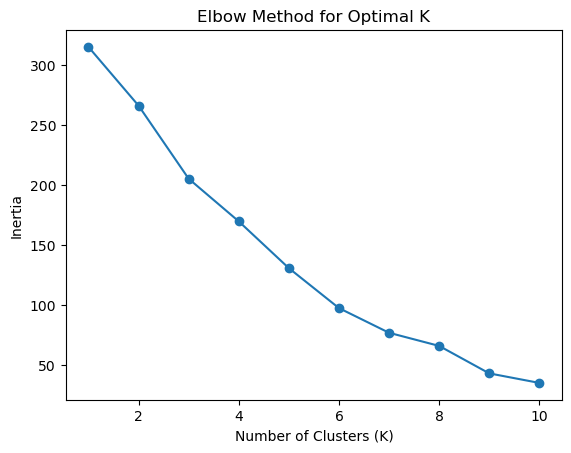

In [78]:
from sklearn.cluster import KMeans

# Try different values of K and calculate the inertia (sum of squared distances)
inertia = []
k_range = range(1, 11)  # Test for K = 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matrix_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia to find the "elbow" point
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


Applies DBSCAN clustering to the standardized data and prints the number of clusters found.

In [79]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN with eps=0.5 and min_samples=5
db = DBSCAN(eps=0.5, min_samples=5)
db_labels = db.fit_predict(matrix_scaled)

# Check the number of distinct clusters
print(f"Number of clusters found by DBSCAN: {len(set(db_labels)) - (1 if -1 in db_labels else 0)}")

Number of clusters found by DBSCAN: 2


Uses the Silhouette Score to evaluate KMeans clustering and selects the best K based on the highest score.

In [80]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

best_score = -1
best_k = 2  # Start with 2 clusters

# Try different values of K and calculate the silhouette score
k_values = range(2, 6)  # Try smaller values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(matrix_scaled)
    
    # Check if there are more than 1 unique labels
    if len(set(kmeans.labels_)) > 1:
        score = silhouette_score(matrix_scaled, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_k = k

print(f"Best number of clusters (K) by silhouette score: {best_k}")

[2025-05-28 01:27:35] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 01:27:35] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(

[2025-05-28 01:27:35] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment varia

Performs Principal Component Analysis (PCA) to reduce the standardized data to 2D and plots the SPOREs in PCA space.

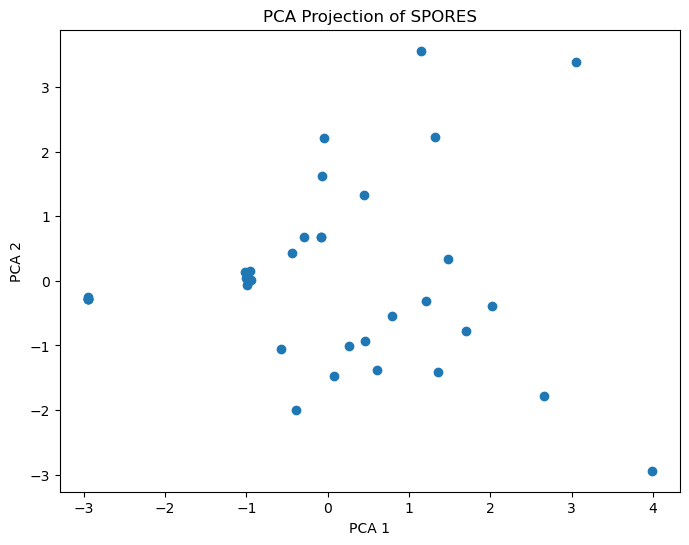

In [81]:
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(matrix_scaled)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA Projection of SPORES')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

Applies KMeans clustering with the chosen number of clusters, assigns cluster labels to each SPORE, and adds them to the aggregated matrix.

In [82]:
# Apply K-means with the chosen number of clusters (e.g., best_k)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(matrix_scaled)

# Add the cluster labels to the DataFrame
aggregated_matrix['Cluster'] = kmeans_labels

# Show the results
aggregated_matrix


[2025-05-28 01:27:40] WARNING  c:\Users\Hewlett-Packard\anaconda3\envs\calliope_NL\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



techs,bioenergy,ccgt,coal,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore,Cluster
spores\maxbat_spore_1,16045.254451,2895.445684,0.011647,3230.094173,3.721065e-09,1487.733845,6460.703627,4133.587573,12419.098827,4
spores\maxbat_spore_2,16079.682601,2870.946341,0.069804,3552.789002,2.090733e-08,1487.751263,6460.703899,4133.587088,12418.254186,4
spores\maxbat_spore_3,16064.476703,2876.685989,0.024541,3879.994531,7.454966e-09,1487.738068,6460.703660,4133.587494,12418.998094,4
spores\maxbat_spore_4,16207.613368,2797.513711,1.498043,3308.526427,6.184824e-07,1488.249338,6460.714893,4133.592228,12351.144275,4
spores\maxbat_spore_5,16383.987528,2711.147792,0.002973,3364.330085,0.000000e+00,1487.731039,6460.703580,4133.587599,12180.738962,4
spores\maxbio_spore_1,24715.600274,2651.214323,1925.416056,933.737436,9.668447e-04,2233.339406,6494.209940,4139.712854,9059.778787,2
spores\maxbio_spore_2,24494.379552,1776.828872,1623.013110,2096.494862,1.439780e-03,2444.202337,6485.075393,4161.988880,9730.100336,2
spores\maxbio_spore_3,12027.539076,10069.452425,164.949306,3054.987696,2.387756e-04,1719.851080,6461.313066,4127.981851,9076.213611,3
spores\maxbio_spore_4,17659.091522,60.544651,246.378466,8886.751504,1.311059e-04,2203.702306,6460.894339,4128.110605,5625.380524,0
spores\maxbio_spore_5,25078.411243,0.920608,2.447413,5575.236192,2.155949e-03,2291.467435,6460.705803,4124.684637,5621.077056,0


Extracts general SPORE categories from SPORE names, groups by cluster and category, and counts occurrences to show the distribution of SPORE types in each cluster.

In [83]:
# Dynamically extract the general SPORE category from the 'techs' index by splitting the names
aggregated_matrix_count = aggregated_matrix.copy()

aggregated_matrix_count['spore_category_general'] = aggregated_matrix_count.index.to_series().apply(lambda x: x.split('_spore')[0])

# Now, group by 'Cluster' and 'spore_category_general' and count the occurrences
cluster_spore_count = aggregated_matrix_count.groupby(['Cluster', 'spore_category_general']).size().unstack(fill_value=0)

# Show the resulting table
cluster_spore_count

spore_category_general,spores\maxbat,spores\maxbio,spores\maxhyd,spores\maxnuc,spores\minbat,spores\minhyd,spores\minnuc
Cluster,,,,,,,
0,0,2,4,0,1,0,1
1,0,0,0,0,1,0,1
2,0,2,0,0,3,0,3
3,0,1,0,0,0,5,0
4,5,0,1,5,0,0,0


Calculates the mean source capacity for each technology within each cluster, summarizing the average configuration per cluster.

In [84]:
# Group by 'Cluster' and calculate the mean for each technology
cluster_summary = aggregated_matrix.groupby('Cluster').mean()

# Show the resulting cluster summary
cluster_summary


techs,bioenergy,ccgt,coal,import_power,lost_load,nuclear,solar_pv,wind_offshore,wind_onshore
Cluster,,,,,,,,,
0,18966.962391,225.355737,1086.294680,5675.531280,7.269820e-04,1657.768299,6461.192697,4142.136337,7715.853258
1,18306.397337,269.607545,3379.454413,6933.657151,1.292269e-01,1652.954269,6477.925681,4155.190846,6996.876271
2,21804.198103,4649.079261,2475.473187,1721.177426,1.772631e-03,2030.817473,6487.247816,4224.872958,8081.819684
3,13885.046969,10640.626107,532.920762,2435.188049,1.757263e-03,1787.765848,6461.889884,4152.239124,7177.365317
4,10238.847214,3011.473633,0.167358,3615.797544,6.457337e-08,9690.288087,6460.704680,4133.587884,12356.275805


Plots a bar chart of the average source capacities by technology for each cluster.

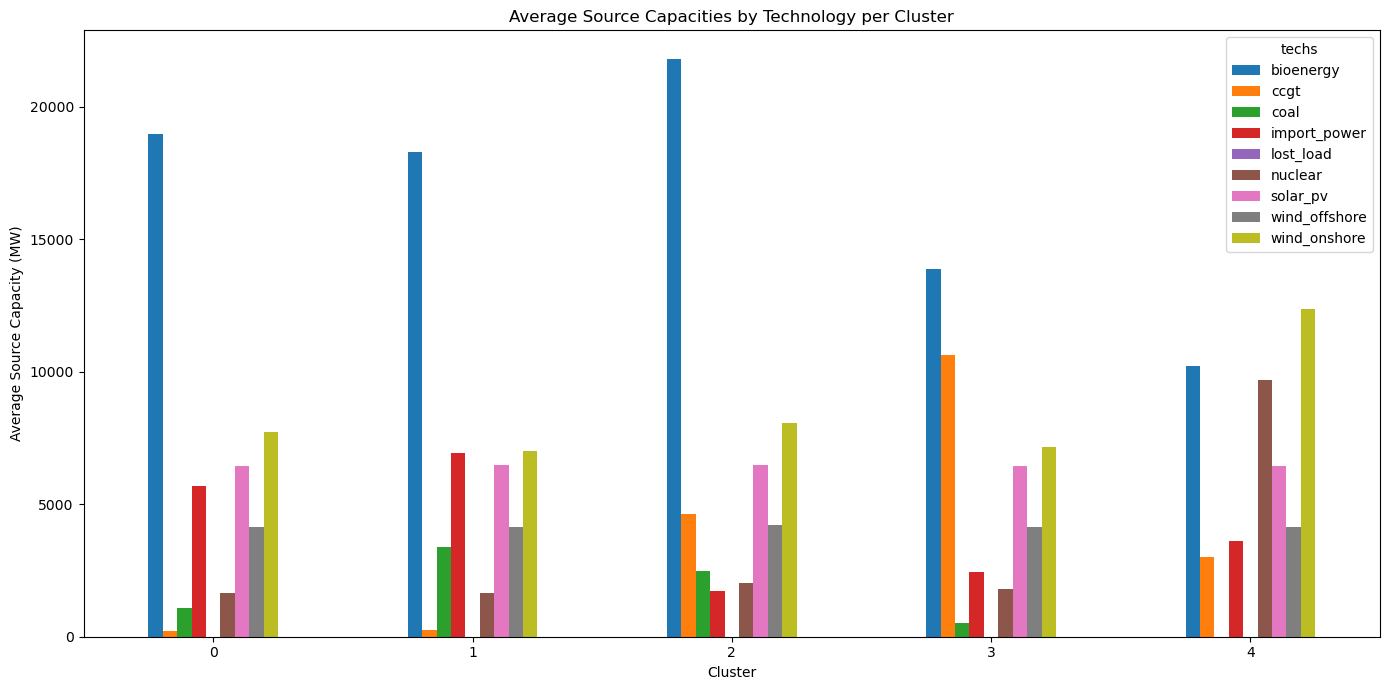

In [85]:
# Plot bar chart for each cluster
cluster_summary.plot(kind='bar', figsize=(14, 7))

plt.title('Average Source Capacities by Technology per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Source Capacity (MW)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Finds the configuration closest to the centroid for each cluster (representative configuration), and plots the technology capacities for these representative SPOREs.

Cluster 4 - Shape of cluster_configs: (11, 9)
Cluster 2 - Shape of cluster_configs: (8, 9)
Cluster 3 - Shape of cluster_configs: (6, 9)
Cluster 0 - Shape of cluster_configs: (8, 9)
Cluster 1 - Shape of cluster_configs: (2, 9)
Representative configurations: ['spores\\maxbat_spore_1', 'spores\\minbat_spore_2', 'spores\\minhyd_spore_4', 'spores\\maxhyd_spore_3', 'spores\\minnuc_spore_5']


<Figure size 1400x700 with 0 Axes>

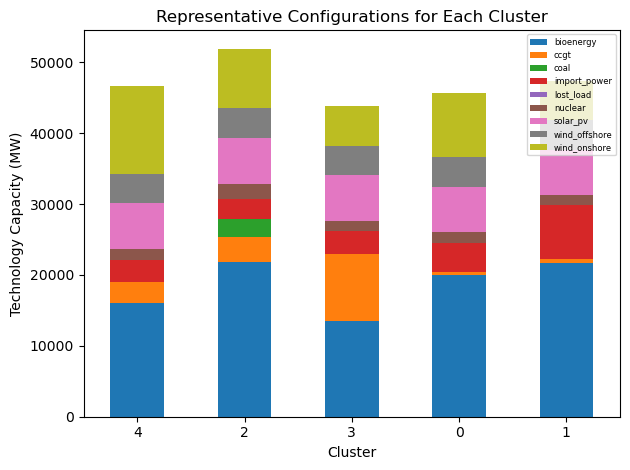

In [86]:
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist
import numpy as np

# Assuming 'aggregated_matrix' is your DataFrame with the 'Cluster' and technology columns
# 1. Compute the centroids of each cluster (mean of each technology in each cluster)
cluster_centroids = aggregated_matrix.groupby('Cluster').mean()

# 2. Find the configuration closest to the centroid for each cluster
representative_configs = []

for cluster in aggregated_matrix['Cluster'].unique():
    # Get the configurations in the current cluster
    cluster_configs = aggregated_matrix[aggregated_matrix['Cluster'] == cluster].drop(columns=['Cluster'])

    # Print the shape of the data to verify it's correct
    print(f"Cluster {cluster} - Shape of cluster_configs: {cluster_configs.shape}")

    # Calculate the centroid for the current cluster
    centroid = cluster_centroids.loc[cluster]

    # Compute the Euclidean distances between each configuration and the centroid
    distances = cdist(cluster_configs, centroid.values.reshape(1, -1), metric='euclidean')

    # Get the index of the closest configuration (minimum distance)
    closest_index = np.argmin(distances)
    representative_config = cluster_configs.iloc[closest_index].name

    # Append the representative configuration's index
    representative_configs.append(representative_config)

# Print the representative configurations' indices
print(f"Representative configurations: {representative_configs}")

# 3. Retrieve the representative configurations from the 'aggregated_matrix'
df_representative_configs = aggregated_matrix.loc[representative_configs]

# 4. Plot the representative configurations (one bar plot per cluster)
plt.figure(figsize=(14, 7))
df_representative_configs.drop(columns=['Cluster']).plot(kind='bar', stacked=True)

# Add titles and labels
plt.title('Representative Configurations for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Technology Capacity (MW)')
plt.xticks(range(len(df_representative_configs)), labels=df_representative_configs['Cluster'], rotation=0)
plt.tight_layout()
plt.legend(loc='upper right', prop={'size': 6})
plt.show()



 Loads all SPORE NetCDF files again, extracts systemwide levelized cost and capacity factor for each technology, and builds a performance metrics matrix indexed by SPORE and technology.

In [92]:
import glob
import xarray as xr
import pandas as pd

# List all the SPORE files (adjust path pattern as needed)
spore_files = glob.glob('results/spores/*.nc')  # Adjust this if needed

# Initialize an empty list to hold the performance metrics for each SPORE
performance_metrics_list = []

# Iterate over each SPORE file
for file in spore_files:
    # Open the NetCDF file
    data = xr.open_dataset(file)
    
    # Extract systemwide levelized cost (LCOE)
    data_sys_LCOE = data['systemwide_levelised_cost'].to_dataframe().reset_index()
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['costs'] == 'monetary']  # Filter for monetary costs
    data_sys_LCOE = data_sys_LCOE[data_sys_LCOE['techs'] != 'lost_load']  # Exclude 'lost_load'
    data_sys_LCOE = data_sys_LCOE[~data_sys_LCOE['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_LCOE = data_sys_LCOE.drop(columns=['costs', 'carriers', 'spores'])  # Drop unnecessary columns
    data_sys_LCOE = data_sys_LCOE[(data_sys_LCOE['techs'] != 'curtailment')&(data_sys_LCOE['techs'] != 'demand_power')&(data_sys_LCOE['techs'] != 'export_power')] # Exclude 'curtailment'
    
    # Extract systemwide capacity factor
    data_sys_cap = data['systemwide_capacity_factor'].to_dataframe().reset_index()
    data_sys_cap = data_sys_cap[~data_sys_cap['techs'].str.contains(r'_to_', regex=True)]  # Exclude techs with '_to_'
    data_sys_cap = data_sys_cap.drop(columns=['carriers', 'spores'])  # Drop unnecessary columns
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'lost_load') & (data_sys_cap['techs'] != 'curtailment')]
    data_sys_cap = data_sys_cap[(data_sys_cap['techs'] != 'demand_power') & (data_sys_cap['techs'] != 'export_power')]  # Exclude 'demand_power' and 'export_power'
    
    # Extract the SPORE name from the file name (e.g., 'maxnuc_spore_1')
    spore_name = file.split('/')[-1].split('.')[0]  # Extracting 'maxnuc_spore_1' from the file name
    
    # Merge the data for the current SPORE (levelized cost and capacity factor)
    performance_metrics_df = pd.DataFrame({
        'systemwide_levelized_cost': data_sys_LCOE.set_index('techs')['systemwide_levelised_cost'],
        'systemwide_capacity_factor': data_sys_cap.set_index('techs')['systemwide_capacity_factor']
    })
    
    # Add the 'techs' column back to the DataFrame for proper indexing
    performance_metrics_df['techs'] = performance_metrics_df.index
    
    # Add the SPORE name as a column for identification
    performance_metrics_df['spore_name'] = spore_name
    
    # Append the performance metrics for this SPORE to the list
    performance_metrics_list.append(performance_metrics_df)

# Combine all performance metrics data into a single DataFrame (with each SPORE as a row)
performance_metrics_matrix = pd.concat(performance_metrics_list, axis=0)

# Reorganize the matrix with 'techs' as the index and 'systemwide_levelized_cost' and 'systemwide_capacity_factor' as columns
performance_metrics_matrix = performance_metrics_matrix.set_index(['spore_name', 'techs'])

# Show the resulting performance metrics matrix
performance_metrics_matrix # Display the first few rows of the matrix for verification


systemwide_levelized_cost  \
spore_name            techs                                               
spores\maxbat_spore_1 battery                                  2.932958   
                      bioenergy                                0.048669   
                      ccgt                                     0.086268   
                      coal                                     0.103516   
                      hydrogen_power_storage                  12.045798   
...                                                                 ...   
spores\minnuc_spore_5 import_power                             0.100000   
                      nuclear                                  0.124775   
                      solar_pv                                 0.314523   
                      wind_offshore                            0.055898   
                      wind_onshore                             0.038879   

                                              systemwide_capacity_factor  
spore_name            techs                                               
spores\maxbat_spore_1 battery                                   0.120896  
                      bioenergy                                 1.000000  
                      ccgt                                      0.294664  
                      coal                                      0.608415  
                      hydrogen_power_storage                    0.307657  
...                                                                  ...  
spores\minnuc_spore_5 import_power                              0.378354  
                      nuclear                                   0.905733  
                      solar_pv                                  0.025265  
                      wind_offshore                             0.383397  
                      wind_onshore                              0.372848  

[350 rows x 2 columns]

For each representative configuration, retrieves the corresponding levelized cost and capacity factor from the performance metrics matrix and builds summary tables for these metrics

In [94]:
# Initialize two lists to hold the levelized cost and capacity factor for each representative configuration
levelized_cost_list = []
capacity_factor_list = []

# Iterate over each representative configuration (row in df_representative_configs)
for config in df_representative_configs.index:
    spore_name = config  # SPORE name as 'techs' holds the SPORE name
    
    # Extract the systemwide levelized cost for each SPORE configuration
    levelized_cost = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_levelized_cost'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    capacity_factor = performance_metrics_matrix.xs(spore_name, level='spore_name')['systemwide_capacity_factor'] if spore_name in performance_metrics_matrix.index.get_level_values('spore_name') else None
    
    # Append the results as rows in the respective lists
    levelized_cost_list.append(levelized_cost)
    capacity_factor_list.append(capacity_factor)

# Convert the lists into DataFrames
df_levelized_cost = pd.DataFrame(levelized_cost_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)
df_capacity_factor = pd.DataFrame(capacity_factor_list, columns=performance_metrics_matrix.index.get_level_values('techs').unique(), index=df_representative_configs.index)

# Display the resulting DataFrames
print("Systemwide Levelized Cost Table:")
print(df_levelized_cost)
print("\nSystemwide Capacity Factor Table:")
print(df_capacity_factor)

Systemwide Levelized Cost Table:
techs                       battery  bioenergy      ccgt      coal  \
spores\maxbat_spore_1      2.932958   0.048669  0.086268  0.103516   
spores\minbat_spore_2   8800.587324   0.052152  0.072014  0.104992   
spores\minhyd_spore_4      0.966760   0.049635  0.059780  0.117248   
spores\maxhyd_spore_3      0.785063   0.048787  0.088094  0.100769   
spores\minnuc_spore_5  39453.759135   0.049184  0.060782  0.169163   

techs                  hydrogen_power_storage  import_power   nuclear  \
spores\maxbat_spore_1            1.204580e+01           0.1  0.114333   
spores\minbat_spore_2            5.596361e+01           0.1  0.157909   
spores\minhyd_spore_4            2.408255e+07           0.1  0.121281   
spores\maxhyd_spore_3            6.876993e+05           0.1  0.114333   
spores\minnuc_spore_5            1.148636e+04           0.1  0.124775   

techs                  solar_pv  wind_offshore  wind_onshore  
spores\maxbat_spore_1  0.314525       0.0557

Displays the DataFrame of systemwide levelized costs for the representative configurations.

In [95]:
df_levelized_cost

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_1,2.932958,0.048669,0.086268,0.103516,1.204580e+01,0.1,0.114333,0.314525,0.055729,0.034719
spores\minbat_spore_2,8800.587324,0.052152,0.072014,0.104992,5.596361e+01,0.1,0.157909,0.314457,0.055898,0.034758
spores\minhyd_spore_4,0.966760,0.049635,0.059780,0.117248,2.408255e+07,0.1,0.121281,0.314525,0.055898,0.038879
spores\maxhyd_spore_3,0.785063,0.048787,0.088094,0.100769,6.876993e+05,0.1,0.114333,0.314525,0.055729,0.034509
spores\minnuc_spore_5,39453.759135,0.049184,0.060782,0.169163,1.148636e+04,0.1,0.124775,0.314523,0.055898,0.038879


Displays the DataFrame of systemwide capacity factor for the representative configurations.

In [96]:
df_capacity_factor

techs,battery,bioenergy,ccgt,coal,hydrogen_power_storage,import_power,nuclear,solar_pv,wind_offshore,wind_onshore
spores\maxbat_spore_1,0.120896,1.000000,0.294664,0.608415,0.307657,0.062240,0.999999,0.025265,0.384564,0.419552
spores\minbat_spore_2,0.059976,0.890444,0.467056,0.596430,0.200524,0.460755,0.697178,0.025271,0.383397,0.419061
spores\minhyd_spore_4,0.394320,0.967019,0.938212,0.512562,0.187800,0.398245,0.935229,0.025265,0.383397,0.372848
spores\maxhyd_spore_3,0.457595,0.995857,0.281358,0.632066,0.000003,0.094603,0.999999,0.025265,0.384564,0.422214
spores\minnuc_spore_5,0.015814,0.982151,0.866617,0.321232,0.197884,0.378354,0.905733,0.025265,0.383397,0.372848
